# **1. Perkenalan Dataset**


# **2. Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# **3. Memuat Dataset**

In [2]:
data = pd.read_csv('personality/marketing_campaign.csv', sep='\t')

print(data.head())
print(data.info())
print(data.describe())

     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

# **4. Exploratory Data Analysis (EDA)**

In [3]:
print(data['Income'].isnull().sum())

24


# **5. Data Preprocessing**

In [4]:
data['Age'] = 2023 - data['Year_Birth']
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')
latest_date = data['Dt_Customer'].max()
data['Tenure'] = (latest_date - data['Dt_Customer']).dt.days
data['TotalChildren'] = data['Kidhome'] + data['Teenhome']
data['TotalSpent'] = data[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
data['TotalPurchases'] = data[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

In [5]:
data['Income'] = data['Income'].fillna(0)
data['Income'] = np.log1p(data['Income'])
data['TotalSpent'] = np.log1p(data['TotalSpent'])
data['Tenure'] = np.log1p(data['Tenure'])

In [6]:
edu_mapping = {'Basic': 0, 'Graduation': 1, 'Master': 2, 'PhD': 3}
data['Education_Encoded'] = data['Education'].map(edu_mapping)

In [7]:

marital_mapping = {'Single': 0, 'Together': 1, 'Married': 1, 'Divorced': 0, 'Widow': 0}
data['Marital_Status_Encoded'] = data['Marital_Status'].map(marital_mapping)

In [8]:
features = ['Income', 'TotalSpent', 'Recency', 'NumWebVisitsMonth', 
            'Education_Encoded', 'Marital_Status_Encoded', 'TotalChildren',
            'Tenure', 'TotalPurchases']
X = data[features]

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

In [10]:
best_k = 3
best_score = 0

In [11]:
X_scaled = SimpleImputer(strategy='mean').fit_transform(X_scaled)

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    
    if score > best_score:
        best_score = score
        best_k = k

kmeans = KMeans(n_clusters=best_k, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

In [12]:
print(f"Cluster Optimal adalah cluster ke-: {best_k} dengan Silhouette Score: {best_score:.2f}")

Cluster Optimal adalah cluster ke-: 2 dengan Silhouette Score: 0.23


## **b. Evaluasi Model Clustering**

In [13]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_filtered = selector.fit_transform(X_scaled)

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_pca)

score = silhouette_score(X_pca, labels)
print(f'Silhouette Score after PCA: {score}')

Silhouette Score after PCA: 0.27184231135581366


## **c. Feature Selection (Opsional)**

## **d. Visualisasi Hasil Clustering**

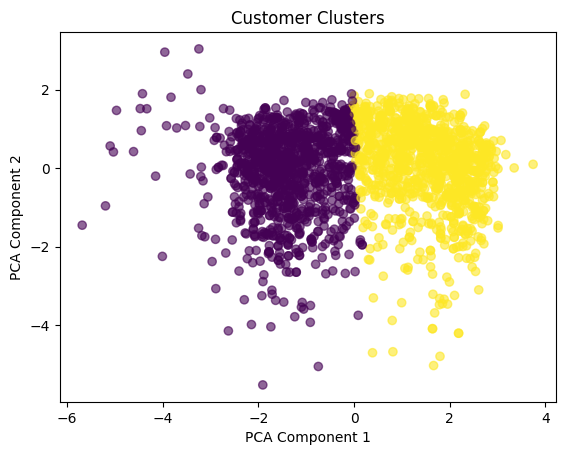

In [15]:
pca = PCA(n_components=2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Customer Clusters')
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

In [16]:
numerical_features = features
X = data[numerical_features]
data[numerical_features] = scaler.inverse_transform(X)

In [17]:
cluster_analysis = data.groupby('Cluster').agg({
    'Income': ['mean', 'min', 'max'],
    'TotalSpent': ['mean', 'min', 'max'],
    'Education': lambda x: x.mode()[0],
    'Marital_Status': lambda x: x.mode()[0],
    'Recency': 'mean',
    'NumWebVisitsMonth': 'mean',
    'TotalChildren': 'mean'
})

In [18]:
for cluster in sorted(data['Cluster'].unique()):
    print(f"\nCluster {cluster}:")
    cluster_data = cluster_analysis.loc[cluster]
    print(f"- Rata-rata Income: {cluster_data['Income']['mean']:.2f}")
    print(f"- Total Belanja Rata-rata: {cluster_data['TotalSpent']['mean']:.2f}")
    print(f"- Pendidikan Paling Umum: {cluster_data['Education']}")
    print(f"- Status Pernikahan Paling Umum: {cluster_data['Marital_Status']}")


Cluster 0:
- Rata-rata Income: 23.05
- Total Belanja Rata-rata: 12.08
- Pendidikan Paling Umum: <lambda>    Graduation
Name: 0, dtype: object
- Status Pernikahan Paling Umum: <lambda>    Married
Name: 0, dtype: object

Cluster 1:
- Rata-rata Income: 24.11
- Total Belanja Rata-rata: 15.74
- Pendidikan Paling Umum: <lambda>    Graduation
Name: 1, dtype: object
- Status Pernikahan Paling Umum: <lambda>    Married
Name: 1, dtype: object


In [19]:
X = data[features]
y = data['Cluster']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

### Interpretasi Target

In [22]:
imputer = SimpleImputer(strategy='mean')

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

for name, model in models.items():
    model.fit(X_train_imputed, y_train)
    y_pred_train = model.predict(X_train_imputed)
    y_pred_test = model.predict(X_test_imputed)
    
    print(f"\n{name} Performance:")
    print(f"Training Accuracy: {accuracy_score(y_train, y_pred_train):.2f}")
    print(f"Training F1-Score: {f1_score(y_train, y_pred_train, average='weighted'):.2f}")
    print(f"Testing Accuracy: {accuracy_score(y_test, y_pred_test):.2f}")
    print(f"Testing F1-Score: {f1_score(y_test, y_pred_test, average='weighted'):.2f}")


Random Forest Performance:
Training Accuracy: 1.00
Training F1-Score: 1.00
Testing Accuracy: 0.98
Testing F1-Score: 0.98

Logistic Regression Performance:
Training Accuracy: 0.99
Training F1-Score: 0.99
Testing Accuracy: 0.99
Testing F1-Score: 0.99


C:\Users\favia\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [23]:
# Save the clustered data to a CSV file
data.to_csv('fish/fish_data.csv', index=False)

print("Clustered data has been saved to 'clustered_fish_data.csv'.")

Clustered data has been saved to 'clustered_fish_data.csv'.
